# Density estimation

Some simple plots for the third lecture of MLD2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.table import Table
from astropy.visualization import hist

# Note that astropy also has a modification of hist that does the same as this one.
#from astroML.plotting import hist
%matplotlib inline

## A table of pulsars

This was downloaded from [Vizier](http://vizier.u-strasbg.fr/cgi-bin/VizieR) - table 1 from [Taylor et al (1995)'s Catalog of pulsars](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=VII/189). 

In [2]:
tPulsar = Table().read('../../../Datafiles/catalog-of-pulsars.vot')

## Finding the Galactic latitude distribution


Pulsars tend to be in the Galactic plane. Let us look at the distribution of latitude

Text(0, 0.5, '# pulsars')

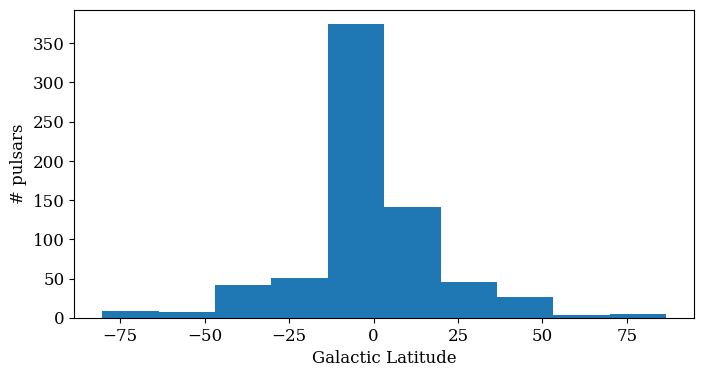

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
h = hist(tPulsar['GLAT'], ax=ax)
ax.set_xlabel('Galactic Latitude')
ax.set_ylabel('# pulsars')

In [4]:
def plot_histogram(data, binning_style, label, ax=None, xmin=-90, xmax=90):
    """
    Convenience routine for plotting a histogram.
    """

    if ax is not None:
        ax = plt.axes(ax)

    # Handle NaN's gracefully.
    keep = np.where(~np.isnan(data))
    
    counts, bins, patches = hist(data[keep], bins=binning_style, ax=ax,
                                 color='k', histtype='step', density=True)
    ax.text(0.95, 0.93, '{0:s}:\n{1:d} bins'.format(label, len(counts)),
            transform=ax.transAxes, ha='right', va='top')

    # Turn off y-axis labeling.
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(xmin, xmax)
    return ax

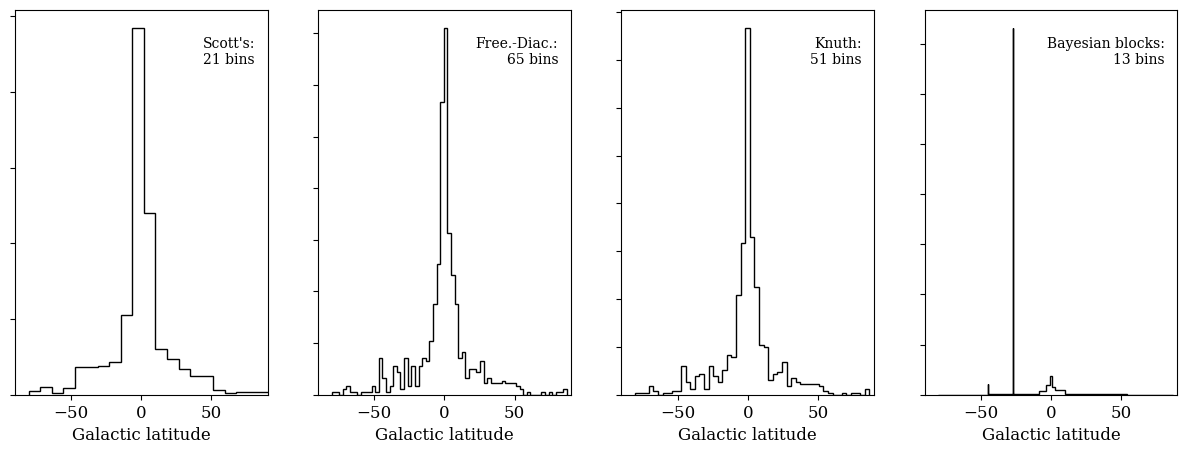

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
styles = ['scott', 'freedman', 'knuth', 'blocks']
titles = ["Scott's", 'Free.-Diac.', 'Knuth', 'Bayesian blocks']
for i in range(len(styles)):

    axis = plot_histogram(tPulsar['GLAT'], styles[i], titles[i], ax=ax[i])
    ax[i].set_xlabel('Galactic latitude')

With a kernel density estimate we can get a smoother distribution (and there seems to be a bug with the Bayesian blocks implementation). To do a kernel density estimate, we can use the `sklearn.neighbors` `KernelDensity` package. Before we do this, it might be useful to illustrate the different kernels available.

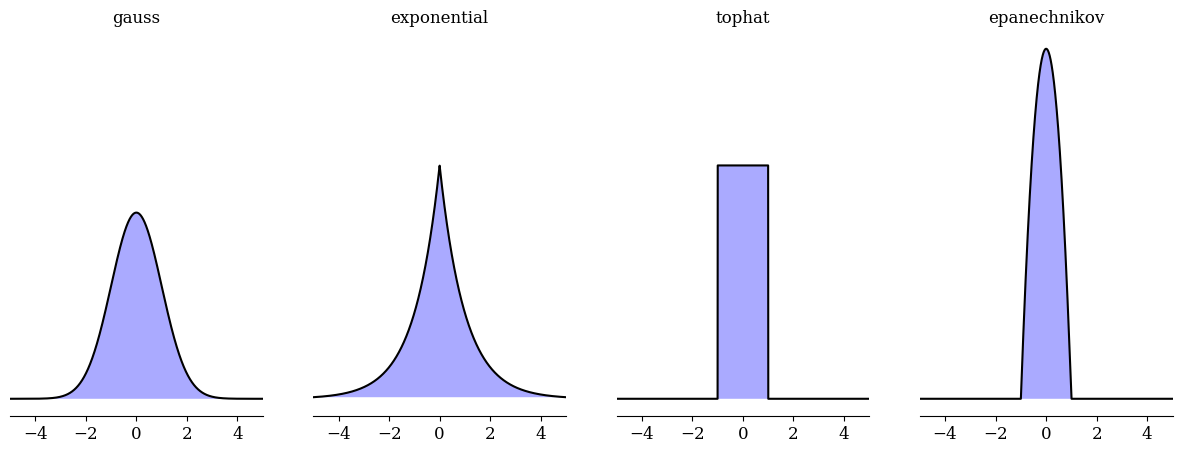

In [6]:
# Show the kernels over -5 to 5
from matplotlib.lines import Line2D
x = np.linspace(-5, 5, 5000)
dx = x[1] - x[0]

kernels = {'gauss': (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2),
           'exponential': 0.5 * np.exp(-abs(x)),
           'tophat': 0.5*np.ones_like(x)*(abs(x) < 1),
           'epanechnikov': 0.75*(1-x*x)*(abs(x) < 1)}
           

fig, axes = plt.subplots(1, 4, sharey=True, frameon=False)
fig.set_size_inches(15, 5)
fig.set_frameon(False)
# fig.figsize(5,15)
for (k, ax) in zip(kernels, axes):

    ax.plot(x, kernels[k], '-', c='black')
    ax.fill(x, kernels[k], '-k', fc='#AAAAFF')

    # This turns off the tick marks on the y-axis and removes the bars on the left, 
    # right and top. 
    ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()

    ax.set_xlim(-5, 5)    
    
    ax.set_title(k)


A key thing you can see in this figure is that the two kernels on the left both are limited to a finite range in x (they have finite support), while the exponential and Gaussian kernels extend to infinity (have infinite support). This can have implementation consequences - in some cases a kernel with finite support can be used to speed up calculations. The Epanechnikov kernel in addition has the nice theoretical property that it minimises variance (is least sensitive to a swap of data).

In [7]:
# I will use the KernelDensity class from Scikit-learn rather than the astroML implementation
# because in the documentation of that function they recommend Scikit-learn.
from sklearn.neighbors import KernelDensity

# from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm

The way the kernel density estimators in `scikit-learn` work is pretty standard: 

First you fit the model to your observable (`.fit` below), then you evaluate the fitted model on new data. This is done with the `score_samples` routine below.

## A KDE estimate for parallax

Here we will take the ideas above and apply them to the parallax of a subset of stars from Gaia.

In [8]:
t = Table().read("../../../Datafiles/gaia-stars.vot")

In [9]:
# Note that sklearn in general wants a 2D array as input - it will, for the moment, 
# work for 1D arrays but complain. The [:, None] construction adds a new final dimension.
X = t['parallax'][:, None]

In [10]:
# Run the fit
kde = KernelDensity(bandwidth=0.1, kernel='gaussian').fit(X)
kde_th = KernelDensity(bandwidth=0.1, kernel='tophat').fit(X)
kde_exp = KernelDensity(bandwidth=0.1, kernel='exponential').fit(X)
kde_ep = KernelDensity(bandwidth=0.1, kernel='epanechnikov').fit(X)



In [11]:
# Create  the grid on which to evaluate the results
xout = np.linspace(0, 1.5, 512)
xout = xout[:, None]

# Then evaluate the KDE solutions
log_dens = kde.score_samples(xout)

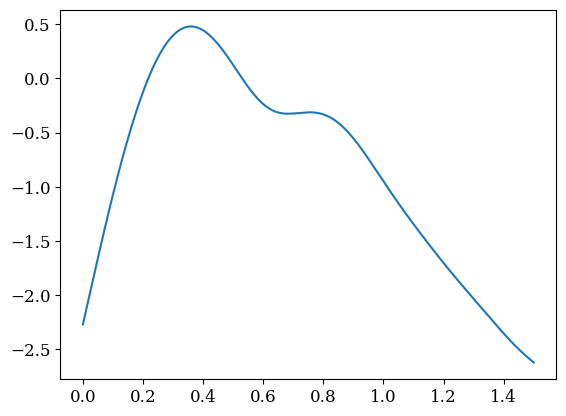

In [12]:
plt.plot(xout, log_dens)

To plot I will first plot the results using the Gaussian kernel and overplot a histogram.

Text(0.5, 0, 'Gaia parallax')

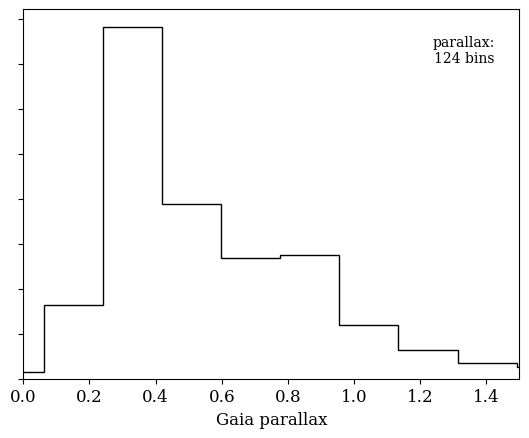

In [13]:
#plt.plot(xout, np.exp(log_dens))
fig, ax = plt.subplots()
y = t['parallax']
keep = np.where(~np.isnan(y))
ax = plot_histogram(y[keep], 'knuth', 'parallax', ax=plt.gca(), xmin=0, xmax=1.5)
ax.set_xlabel('Gaia parallax')

Let us now compare the different kernels.

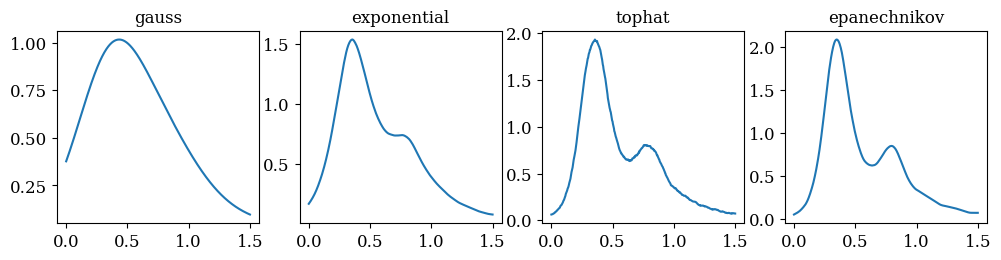

In [30]:
results = {'gauss': kde,
           'exponential': kde_exp,
           'tophat': kde_th,
           'epanechnikov': kde_ep}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2.5))
for i, key in enumerate(results.keys()):
    log_density = results[key].score_samples(xout)
    axes[i].plot(xout, np.exp(log_density))
    axes[i].set_title(key)

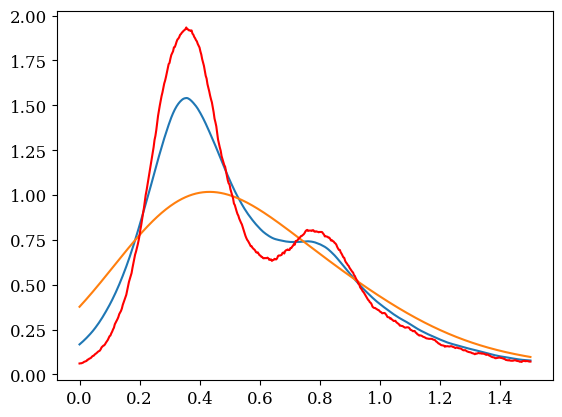

In [31]:
model_exponential = kde_exp # 
log_likelihood = model_exponential.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood))

model_gaussian = kde # 
log_likelihood = model_gaussian.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood))

model_tophat = kde_th # 
log_likelihood = model_tophat.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood), color='red')

In [15]:
from sklearn.model_selection import KFold

def cv1(x, bws, model='gaussian', plot=False, n_splits=10):
    """
    Estimate bandwidth using leave-one-out cross-validation
    
    Input:
       x: data (assumed 1D)
       bws: Bandwidths to test (assumed 1D)
       
    Keywords:
       model: The kernel to use (default='gaussian')
       plot: Set this to true to show a big grid of the test and training
             samples with the KDE chosen at each step. This is not robust!
       n_splits: the number of folds to split the data into. Default=10.
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_splits), figsize=(15, 8))
        xplot = np.linspace(np.min(x), np.max(x), 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(n_splits=n_splits)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf.split(X):
            x_train = x[train, :]
            x_test = x[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=model, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Calculate the average likelihood          
        cv_1[i] = lnP/N
        
    return cv_1


Armed with this function, we can now get the cross-validation score.

In [16]:
X = t['parallax'][:, np.newaxis] # A different way to add a new axis = [:, None]
bws = np.linspace(0.05, 1, 50)
cv = cv1(X, bws)

Text(4, 0.001, 'Best BW=0.2439')

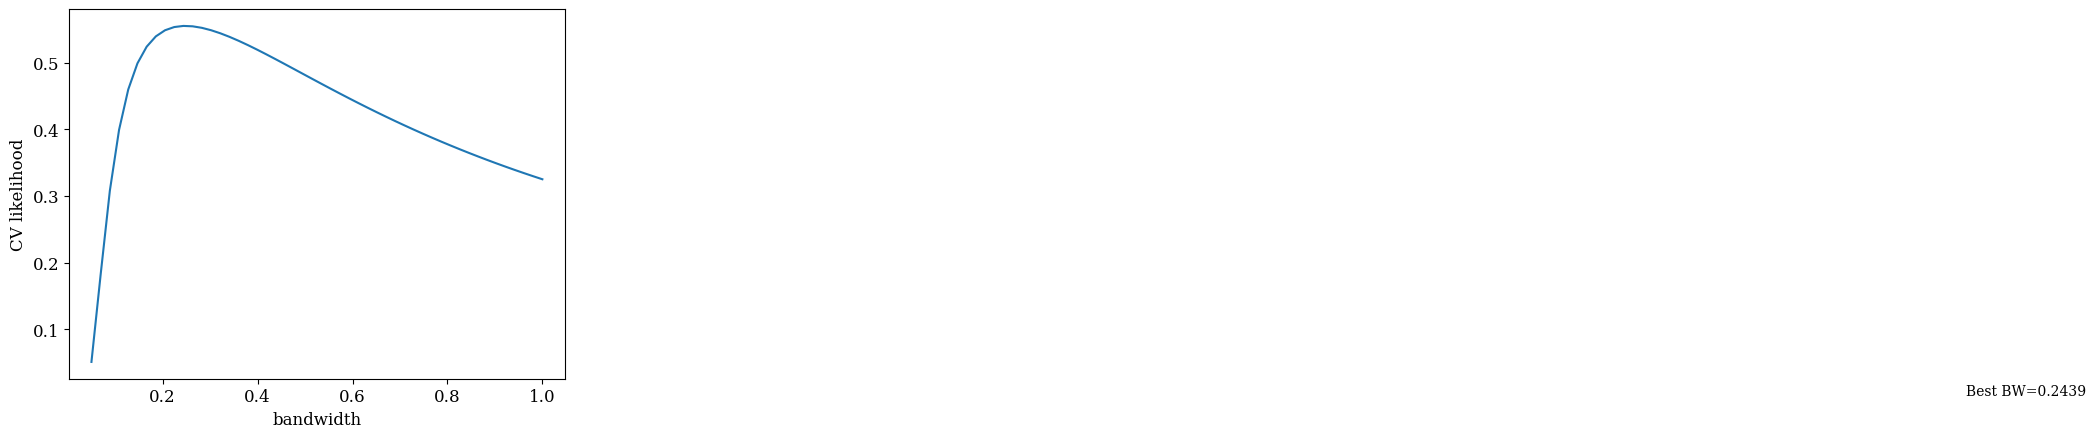

In [17]:
plt.plot(bws, np.exp(cv))
plt.xlabel('bandwidth')
plt.ylabel('CV likelihood')
plt.text(4, 0.001, 'Best BW={0:.4f}'.format(bws[np.argmax(cv)]))

You can improve (possibly) on this estimate by interpolation - this is more useful when you calculate the cross-validation score on a coarse grid.

In [18]:
bw_big = np.linspace(0.05, 1, 1000)
cv_big = np.interp(bw_big, bws, cv)
print("The linearly interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big)]))

The linearly interpolated maximum is=0.2440


In [19]:
from scipy import interpolate
f = interpolate.interp1d(bws, cv, kind=3)
cv_big2 = f(bw_big)
print("The quadratically interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big2)]))

The quadratically interpolated maximum is=0.2478


In [20]:
# U will use the quadratically interpolated maximum as the best
best_bw = bw_big[np.argmax(cv_big2)]

In practice the two are very close but the maximum is not terribly well constrained.

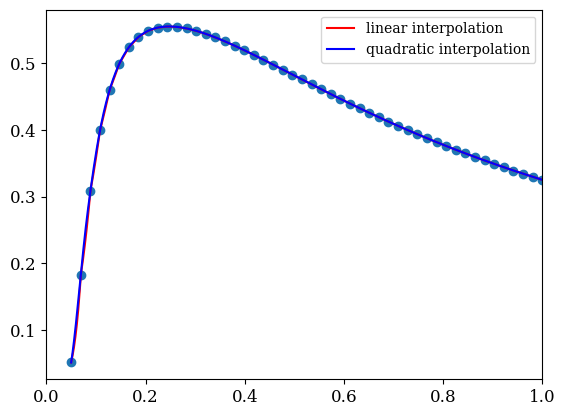

In [21]:
plt.plot(bws, np.exp(cv), 'o')
plt.plot(bw_big, np.exp(cv_big), 'r', label='linear interpolation')
plt.plot(bw_big, np.exp(cv_big2), 'b', label='quadratic interpolation')
plt.xlim(0, 1)
#plt.ylim(0.011, 0.0132)
plt.legend()

So let us see the result

In [22]:
kde = KernelDensity(bandwidth=best_bw, kernel='gaussian').fit(X)

Text(0.5, 1.0, 'Best bandwidth from CV')

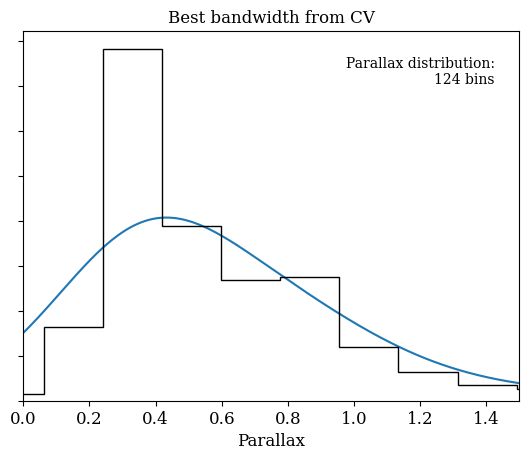

In [23]:
# We use the output grid defined above.

# Then evaluate the KDE solutions
log_dens = kde.score_samples(xout)

plt.plot(xout, np.exp(log_dens))
ax = plot_histogram(t['parallax'], 'knuth', 'Parallax distribution', ax=plt.gca(), xmin=0, xmax=1.5)
ax.set_xlabel('Parallax')
ax.set_title('Best bandwidth from CV')

# Gaussian mixture models


In [ ]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(2)

In [ ]:
res = model.fit(X)

We can get the means of the two Gaussians and 

In [ ]:
labels = res.predict(X)

In [ ]:
plt.scatter(t['parallax'][labels==0], t['b'][labels==0], color='red')
plt.scatter(t['parallax'][labels==1], t['b'][labels==1], color='blue')